# Word2vec model based on Fetahu
This model uses a pretrained word2vec to vectorize the paragraphs, the sequential information of the sentences is maintained.

A pretrained word2vec can be found on [this github repo](https://github.com/3Top/word2vec-api).

The paper this is based on can be found [here](https://arxiv.org/pdf/1811.05740.pdf).

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from sklearn.metrics import confusion_matrix
from gensim.utils import simple_preprocess
import itertools
import nltk
from gg_doc2vec import read_corpus, ggdoc2vec_train
from sklearn.metrics import roc_curve, auc

## Download and transform a tagset from NLTK
The part-of-speech tags used can be viewed by:

In [2]:
#nltk.help.upenn_tagset()

In [3]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
nltk.download('tagsets')

[nltk_data] Downloading package tagsets to /home/ubuntu/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

In [5]:
pos_tags_list = np.array(['CC', 'CD', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS','NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', 'DT', "''"] )

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# transform to integer
X_int = LabelEncoder().fit(pos_tags_list.reshape(-1, 1))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [41]:
df = pd.read_csv("../../data/ad_hominem/ad_hominems_cleaned_Murilo.csv", sep=",", index_col=0, header=0, names=["body", "isAdHominem"])
df = df[~df.isin([np.nan, np.inf, -np.inf, 'nan']).any(1)] ## Remove rows with NaN values

In [42]:
df["length"] = df["body"].apply( lambda x: len(simple_preprocess(x, deacc=True)))

In [43]:
df.drop(df[df["length"] > 150].index, axis=0, inplace=True)

In [44]:
df.shape

(25467, 3)

In [45]:
print("Setting paragraph length at {} words.".format(df["length"].max()))

Setting paragraph length at 150 words.


In [46]:
from sklearn.model_selection import train_test_split

train, test = train_test_split( df, test_size=0.3, random_state=1)

print("In total, the train contains", sum(train["isAdHominem"] == True), "ad hominems")
print("In total, the test contains", sum(test["isAdHominem"] == True), "ad hominems")

In total, the train contains 1494 ad hominems
In total, the test contains 652 ad hominems


In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
print("importing word2vec")
wv_from_bin = KeyedVectors.load_word2vec_format("~/notebooks/word2vec-GoogleNews-vectors/GoogleNews-vectors-negative300.bin.gz", binary=True)  # C binary format
print("imported word2vec")

importing word2vec
imported word2vec


In [48]:
docVectorLength = 500
docModel = ggdoc2vec_train(train, vec_size=docVectorLength)

In [49]:
def combineData( dataset, maxLength, docVectorLength ):
    #dataset["length"] = dataset["body"].apply( lambda x: len(word_tokenize(x)))
    #maxLength = dataset["length"].max()    
    paragraphRepresentations = np.zeros((len(dataset), maxLength, 300))
    docVectors = np.zeros((len(dataset), docVectorLength))
    tags = np.zeros((len(dataset), maxLength, len(pos_tags_list)))
    
    for i, paragraph in enumerate(dataset["body"]):
        if (100* i / dataset.shape[0] % 10 == 0):
            print("{} of {} ({} %)\r".format(i, dataset.shape[0], 100* i / dataset.shape[0]))
        
        # Split the sentence into an array of (cleaned) words
        splittedSentence = simple_preprocess(paragraph, deacc=True)
        if len(splittedSentence) != 0:
            for index, tag in enumerate(X_int.transform(np.array(nltk.pos_tag(splittedSentence))[:,1])):
                tags[i, index, tag] = 1.
        # Generate docVector first
        docVectors[i] = docModel.infer_vector(splittedSentence)
        
        # Enumerate over the words in the tags-array (col 0 = words, col 1 = POS tags)
        for j, word in enumerate(splittedSentence):
            #print("{}: {} ({})".format(i, j, word))
            if word.lower() in wv_from_bin:
                paragraphRepresentations[i, j] = wv_from_bin[word.lower()] 
    return paragraphRepresentations, docVectors, tags

In [50]:
maxLength = df["length"].max() 
print("Start train data")
train_vectors, train_doc_vectors, train_tags = combineData(train, maxLength, docVectorLength)

Start train data
0 of 17826 (0.0 %)
8913 of 17826 (50.0 %)


In [51]:
test_vectors, test_doc_vectors, test_tags = combineData(test, maxLength, docVectorLength)

0 of 7641 (0.0 %)


In [52]:
batch_size = 50
epochs = 6

## Fix imbalance
Since classes are imbalanced, this needs to be handled. Sklearn offers a nice function, whose weights can then be used in the keras model.

In [53]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train["isAdHominem"]),
                                                 train["isAdHominem"])

In [54]:
class_weights

array([0.55, 5.97])

In [55]:
from keras.layers import Input, Embedding, GRU, Dense, Masking, Bidirectional, concatenate, Dropout,Flatten
from keras.models import Model

word2vecInput = Input(shape=(maxLength, 300), name='word2vec')
doc2vecInput = Input(shape=(docVectorLength,), name='doc2vec')
posTagsInput = Input(shape=(maxLength, len(pos_tags_list)), name='pos_tags')

# Network for word vectors
x = Masking(mask_value=0., input_shape=(maxLength, 300))(word2vecInput)
#x = Bidirectional(GRU(100, return_sequences=True), merge_mode='ave')(x) 
wordout = Bidirectional(GRU(100, activation="relu"), merge_mode='ave')(x)

# Add another network for the pos tags
x = Masking(mask_value=0., input_shape=(maxLength, len(pos_tags_list)))(posTagsInput)
posout = Bidirectional(GRU(100, activation="relu"), merge_mode='ave')(x)

# Add word vectors and doc vectors together
x = concatenate([wordout, doc2vecInput, posout])
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
output = Dense(2, activation="sigmoid", name="output")(x)

model = Model(inputs=[word2vecInput, doc2vecInput, posTagsInput], outputs=[output])

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [56]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word2vec (InputLayer)           (None, 150, 300)     0                                            
__________________________________________________________________________________________________
pos_tags (InputLayer)           (None, 150, 36)      0                                            
__________________________________________________________________________________________________
masking_3 (Masking)             (None, 150, 300)     0           word2vec[0][0]                   
__________________________________________________________________________________________________
masking_4 (Masking)             (None, 150, 36)      0           pos_tags[0][0]                   
__________________________________________________________________________________________________
bidirectio

In [57]:
history = model.fit(
            {'word2vec': train_vectors, 'doc2vec': train_doc_vectors, 'pos_tags': train_tags},
            {'output': np.array([1-train["isAdHominem"], train["isAdHominem"]]).T},
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            validation_split=0.1,
            class_weight=class_weights)

Train on 16043 samples, validate on 1783 samples
Epoch 1/6
16043/16043 [==============================] - 284s 18ms/step - loss: 0.2745 - binary_accuracy: 0.9151 - val_loss: 0.2030 - val_binary_accuracy: 0.9246
Epoch 2/6
16043/16043 [==============================] - 283s 18ms/step - loss: 0.2140 - binary_accuracy: 0.9191 - val_loss: 0.2255 - val_binary_accuracy: 0.9232
Epoch 3/6
16043/16043 [==============================] - 284s 18ms/step - loss: 0.1967 - binary_accuracy: 0.9255 - val_loss: 0.1879 - val_binary_accuracy: 0.9288
Epoch 4/6
16043/16043 [==============================] - 283s 18ms/step - loss: 0.1830 - binary_accuracy: 0.9299 - val_loss: 0.1881 - val_binary_accuracy: 0.9279
Epoch 5/6
16043/16043 [==============================] - 282s 18ms/step - loss: 0.1701 - binary_accuracy: 0.9327 - val_loss: 0.1896 - val_binary_accuracy: 0.9313
Epoch 6/6
16043/16043 [==============================] - 282s 18ms/step - loss: 0.1609 - binary_accuracy: 0.9352 - val_loss: 0.1861 - val_bin

## Automaticaly determine best threshold
To find the best theshold value, all the training data is evaluated and the max value for the AUC is found.

In [58]:
train_predicted = model.predict({'word2vec': train_vectors, 'doc2vec': train_doc_vectors, 'pos_tags': train_tags})

In [59]:
def generate(start, end, stepsize):
    steps = (end - start)/stepsize + 1
    for x in range(0, int(steps)):
        yield start + x*stepsize
steps = np.fromiter(generate(0.5, 1.0, 0.01), float)
    
def getAUC(steps):
    for x in steps:
        false_positive_rate, true_positive_rate, thresholds = roc_curve(train["isAdHominem"], train_predicted[:,0] < x)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        yield [x, roc_auc]

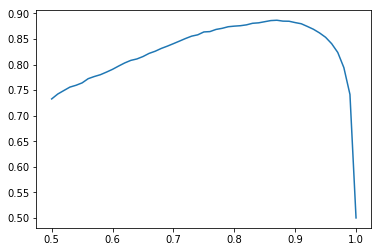

In [60]:
aucValues = np.array(list(getAUC(steps)), float)
plt.plot(aucValues[:,0], aucValues[:,1])


In [61]:
topValue = aucValues[ aucValues[:,1].max() == aucValues[:,1]][0,0]
print("Based on the training data, the threshold is set at {}.". format(topValue))

Based on the training data, the threshold is set at 0.87.


## Evaluate on test set

In [62]:
test_predicted = model.predict({'word2vec': test_vectors, 'doc2vec': test_doc_vectors, 'pos_tags': test_tags})

In [63]:
model.save_weights("model_crazyMizedNN-150words.h5")

Confusion matrix, without normalization
[[5980 1009]
 [ 172  480]]
Normalized confusion matrix
[[0.86 0.14]
 [0.26 0.74]]


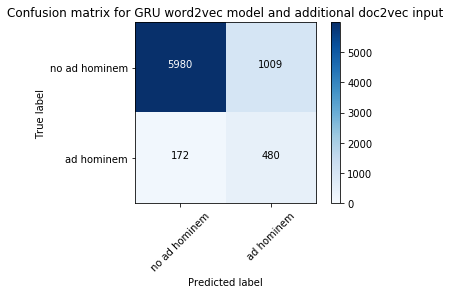

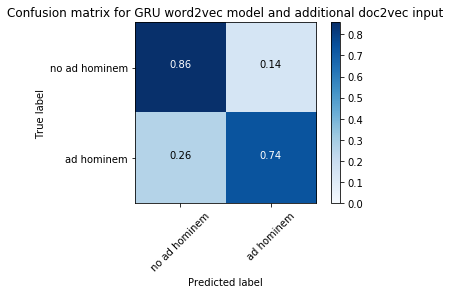

In [64]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test["isAdHominem"], test_predicted[:,0] < topValue)

np.set_printoptions(precision=2)

title="Confusion matrix for GRU word2vec model and additional doc2vec input"

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["no ad hominem", "ad hominem"],normalize=False, 
                      title=title)

#print('plots exported.png')
#fig.savefig("model06_not_normalized.png")

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["no ad hominem", "ad hominem"],normalize=True, 
                      title=title)
#fig.savefig("model06_normalized.png")

## Finally evaluate loss on train and validation set

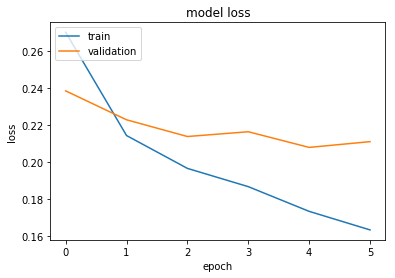

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

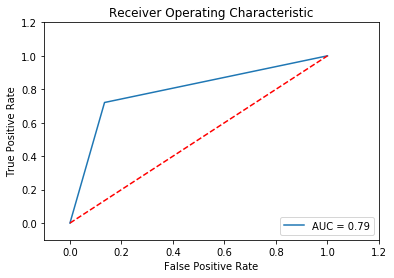

In [31]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test["isAdHominem"], test_predicted[:,0] < topValue)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate,
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
